### Step 1: Load data

In [1]:
import os

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, precision_recall_curve
from skmultilearn.model_selection import IterativeStratification
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm import tqdm

from ChestXRayDataset import ChestXRayDataset
from MultiSourceChestXRayDataset import MultiSourceChestXRayDataset

In [2]:
df_train = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_train.csv')
df_val = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_val.csv')
df_test = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_test.csv')

train_augmented_df = pd.read_csv('../data/data_entries/augmented_images_v3.csv')

In [3]:
df_train.shape, df_val.shape, df_test.shape, train_augmented_df.shape

((78506, 22), (12533, 22), (21081, 22), (13731, 23))

In [4]:
# Count classes to determinate majority classes
class_counts = df_train.iloc[:, 1:-2].sum(axis=0)
class_counts

Atelectasis                    7587
Cardiomegaly                   1590
Consolidation                  2626
Edema                          1283
Effusion                       7919
Emphysema                      1327
Fibrosis                       1138
Hernia                          130
Infiltration                  12739
Mass                           3689
Nodule                         4359
Pleural Thickening             1998
Pneumonia                       806
Pneumothorax                   2432
Pneumoperitoneum                214
Pneumomediastinum                88
Subcutaneous Emphysema          957
Tortuous Aorta                  598
Calcification of the Aorta      368
dtype: int64

Some images exist in images folder, but not in miccai labels and opposite

To fix this problem We create list of all image IDs in both train and test _images folder
then ensure that only images withing this list are loaded to dataset

In [5]:
image_dir_train = 'data/train_images'
image_dir_test = 'data/test_images'
# Define function to get valid image ids that exist in the image directory
def get_valid_image_ids(df, image_dir):
    # Get the set of image IDs that exist in the image directory
    image_files = set(os.listdir(image_dir))  # List of all files in the image directory
    # Check if image id exists in the image directory
    valid_ids = df[df['id'].isin(image_files)]['id']
    return valid_ids

In [6]:
# Get valid image ids for train and test datasets
valid_train_ids = get_valid_image_ids(df_train, image_dir_train)
valid_val_ids = get_valid_image_ids(df_val, image_dir_train)
valid_test_ids = get_valid_image_ids(df_test, image_dir_test)

In [7]:
# Filter the DataFrames to include only the valid image IDs
df_train_valid = df_train[df_train['id'].isin(valid_train_ids)]
df_val_valid = df_val[df_val['id'].isin(valid_val_ids)]
df_test_valid = df_test[df_test['id'].isin(valid_test_ids)]

df_train_valid.shape, df_val_valid.shape, df_test_valid.shape

((78506, 22), (8018, 22), (21081, 22))

In [8]:
df_train_val = pd.concat([df_train_valid, df_val_valid], ignore_index=True)
assert df_train_val.shape[0] == df_train_valid.shape[0] + df_val_valid.shape[0]

In [9]:
df_train_val.drop(df_train_val[df_train_val['No Finding'] == 1].index, inplace=True)
df_test_valid.drop(df_test_valid[df_test_valid['No Finding'] == 1].index, inplace=True)
df_train_val.shape, df_test_valid.shape

((36778, 22), (13066, 22))

In [10]:
df_train_val = df_train_val.copy()
df_train_val.drop(columns=['subj_id', 'No Finding'], inplace=True)
df_train_val.shape

(36778, 20)

In [11]:
## Do same for testing
df_test_valid = df_test_valid.copy()
df_test_valid.drop(columns=['subj_id', 'No Finding'], inplace=True)
df_test_valid.shape

(13066, 20)

### Drop majority classes and keep only minority for model C

In [12]:
# Count classes to determinate majority classes
class_counts = df_train_val.iloc[:, 1:].sum(axis=0)
class_counts

Atelectasis                    8280
Cardiomegaly                   1707
Consolidation                  2852
Edema                          1378
Effusion                       8659
Emphysema                      1423
Fibrosis                       1251
Hernia                          141
Infiltration                  13782
Mass                           4034
Nodule                         4708
Pleural Thickening             2242
Pneumonia                       876
Pneumothorax                   2637
Pneumoperitoneum                231
Pneumomediastinum                92
Subcutaneous Emphysema         1023
Tortuous Aorta                  634
Calcification of the Aorta      395
dtype: int64

In [13]:
majority_threshold = 3000
minority_classes = class_counts[class_counts < majority_threshold].index.tolist()
minority_classes

['Cardiomegaly',
 'Consolidation',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Pleural Thickening',
 'Pneumonia',
 'Pneumothorax',
 'Pneumoperitoneum',
 'Pneumomediastinum',
 'Subcutaneous Emphysema',
 'Tortuous Aorta',
 'Calcification of the Aorta']

In [14]:
columns_to_keep = ['id'] + minority_classes
df_train_val = df_train_val[columns_to_keep]
df_test_valid = df_test_valid[columns_to_keep]

train_augmented_df = train_augmented_df[columns_to_keep]

In [15]:
df_train_val.shape, df_test_valid.shape, train_augmented_df.shape

((36778, 15), (13066, 15), (13731, 15))

In [16]:
df_train_val.sample(2)

,id,Cardiomegaly,Consolidation,Edema,Emphysema,Fibrosis,Hernia,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta
46243,00015105_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
81552,00017110_005.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
train_augmented_df.sample(2)

,id,Cardiomegaly,Consolidation,Edema,Emphysema,Fibrosis,Hernia,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta
1140,00007916_007_6848.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1814,00030000_002_5199.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Concat train_augmented_df and df_train_val, but we do following steps in order
- Create 'is_augmented' column to seperate between orginal and augmented data/images
- Concat both DataFrame's
- Drop all rows that has sum 0, meaning no minority classes found
- Finally create 'finding' and 'finding_encoded' columns

In [18]:
df_train_val['is_augmented'] = False
train_augmented_df['is_augmented'] = True

In [19]:
# Concatenate both DataFrames
combined_df = pd.concat([df_train_val, train_augmented_df], ignore_index=True)
assert combined_df.shape[0] == df_train_val.shape[0] + train_augmented_df.shape[0]

In [20]:
combined_df.shape

(50509, 16)

In [21]:
combined_df = combined_df.loc[combined_df.iloc[:, 1:].sum(axis=1) > 0]
df_test_valid = df_test_valid.loc[df_test_valid.iloc[:, 1:].sum(axis=1) > 0]
combined_df.shape, df_test_valid.shape

((27720, 16), (6789, 15))

In [22]:
combined_df.sample(2)

,id,Cardiomegaly,Consolidation,Edema,Emphysema,Fibrosis,Hernia,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,is_augmented
34614,00008175_000.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,False
49741,00010261_005_7348.png,0,0,0,0,0,0,0,0,0,1,0,0,0,0,True


### Step 2: Label encoding and create target column 

#### Step 2.1: create mappings variable for all categories we have

In [23]:
# Extract all categories (exclude 'id' and 'is_augmented')
categories = combined_df.columns[1:-1]

# Create a mapping dictionary for categories to numbers
category_mapping = {category: idx for idx, category in enumerate(categories)}

print("Category Mapping:")
print(category_mapping)

Category Mapping:
{'Cardiomegaly': 0, 'Consolidation': 1, 'Edema': 2, 'Emphysema': 3, 'Fibrosis': 4, 'Hernia': 5, 'Pleural Thickening': 6, 'Pneumonia': 7, 'Pneumothorax': 8, 'Pneumoperitoneum': 9, 'Pneumomediastinum': 10, 'Subcutaneous Emphysema': 11, 'Tortuous Aorta': 12, 'Calcification of the Aorta': 13}


### Step 2.3: Create finding column

This column will contain list of all finding categories for each image, and we have the following scenarios
1. The image has no sickness ==> finding column is a list with only one item 'No Finding'
2. The image contains only one category i.g 'Hernia' ==> finding column is a list with only one item 'Hernia'
3. The image contains more than one category i.g 'Hernia' and 'Edema'...etc. ==> finding column is a list finding items 'Hernia' and 'Edema'

In [24]:
# Function to create 'finding' and 'finding_encoded' as a string based on category values
def create_finding(row):
    # Generate lists of findings and their encoded values
    findings = [category for category in categories if row[category] == 1]
    encoded_findings = [str(category_mapping[category]) for category in findings]
    
    # Join encoded findings as a single string for stratification
    return findings, ','.join(encoded_findings)


In [25]:
# Apply function to create 'finding' and 'finding_encoded' columns in train_val data
combined_df[['finding', 'finding_encoded']] = combined_df.apply(
    lambda row: pd.Series(create_finding(row)), axis=1
)

combined_df[['id', 'finding', 'finding_encoded']]

,id,finding,finding_encoded
0,00000001_000.png,[Cardiomegaly],0
1,00000001_001.png,"[Cardiomegaly, Emphysema]","0,3"
2,00000001_002.png,[Cardiomegaly],0
6,00000008_000.png,[Cardiomegaly],0
7,00000008_002.png,[Calcification of the Aorta],13
...,...,...,...
50504,00026791_002_7504.png,[Hernia],5
50505,00026791_002_5599.png,[Hernia],5
50506,00026791_002_8240.png,[Hernia],5
50507,00026791_002_5744.png,[Hernia],5


In [26]:
# Apply function to create 'finding' and 'finding_encoded' columns in test data
df_test_valid[['finding', 'finding_encoded']] = df_test_valid.apply(
    lambda row: pd.Series(create_finding(row)), axis=1
)

df_test_valid[['id', 'finding', 'finding_encoded']]

,id,finding,finding_encoded
1,00000013_001.png,"[Emphysema, Pneumothorax, Subcutaneous Emphysema]","3,8,11"
2,00000013_002.png,"[Emphysema, Pneumothorax, Subcutaneous Emphysema]","3,8,11"
3,00000013_003.png,[Pleural Thickening],6
4,00000013_004.png,"[Emphysema, Pneumothorax, Subcutaneous Emphysema]","3,8,11"
5,00000013_005.png,"[Emphysema, Pleural Thickening, Pneumothorax, ...","3,6,8,11"
...,...,...,...
20961,00030637_012.png,[Pneumothorax],8
20965,00030637_016.png,"[Consolidation, Pneumonia]","1,7"
20999,00030674_000.png,[Tortuous Aorta],12
21001,00030677_000.png,[Fibrosis],4


### Step 3: Create subsets and DataLoaders for the training, validation, and test sets

In [27]:
# Image transformation for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
train_val_ratio = 0.8 # For train, val ratio

#### Create dataset's and dataloader's

**First: create the subset**

In [29]:
# Perform the stratified split
label_matrix = combined_df['finding_encoded'].str.get_dummies(sep=',')
stratifier = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[train_val_ratio, 1 - train_val_ratio]) 
val_indices, train_indices = next(stratifier.split(combined_df, label_matrix))

train_df = combined_df.iloc[train_indices].reset_index(drop=True)
val_df = combined_df.iloc[val_indices].reset_index(drop=True)

# Verify the sizes
print(f"Train size (80% of subset): {len(train_df)} rows")
print(f"Val size (20% of subset): {len(val_df)} rows")

Train size (80% of subset): 22375 rows
Val size (20% of subset): 5345 rows


In [30]:
assert combined_df.shape[0] == train_df.shape[0]+ val_df.shape[0]

#### Step 3.2: Create dataset objects


In [31]:
# Define image directories
image_dirs = {
    'train': '../data/train_images',
    'augmented': '../data/oversampled_train'
}

In [32]:
train_dataset = MultiSourceChestXRayDataset(
    dataframe=train_df,
    image_dirs=image_dirs,
    category_mapping=category_mapping,
    transform=val_transform,
    augment_transform=train_transform
)

val_dataset = MultiSourceChestXRayDataset(
    dataframe=val_df,
    image_dirs=image_dirs,
    category_mapping=category_mapping,
    transform=val_transform,
    augment_transform=val_transform
)

# Create Dataset for df_test_valid (since it's small, we don't need to subset)
test_dataset = ChestXRayDataset(dataframe=df_test_valid, image_dir=image_dir_test, category_mapping=category_mapping, transform=val_transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


#### Step 3.3: Create dataloaders

In [33]:
# Create Dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [34]:
print(f"Training DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Testing DataLoader: {len(test_loader)} batches")

Training DataLoader: 700 batches
Validation DataLoader: 168 batches
Testing DataLoader: 213 batches


In [35]:
img, label, img_id = train_dataset[100]
print(f"Image ID: {img_id}")
print(f"Label: {label}")
print(f"Image Shape: {img.shape}")

Image ID: 00000372_016.png
Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Image Shape: torch.Size([3, 224, 224])


In [36]:
train_df[train_df.id == img_id]

,id,Cardiomegaly,Consolidation,Edema,Emphysema,Fibrosis,Hernia,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,is_augmented,finding,finding_encoded
100,00000372_016.png,0,0,0,0,0,0,0,0,0,0,0,0,1,0,False,[Tortuous Aorta],12


### Step 4: Define the model
We use pretrained ResNet

- ResNet-50 is designed for single label classification
- We add linear layer to predict multi-label ( more than one category per image)
- ResNet-50 designed to output 2048 features
- We add two Linear layer to avoid going down from 2048 features to only 20 which may cause instability and overfitting

**Note**: as first step we do not add any additional params/functionality to the network i.g Dropout, normal...etc

In [37]:
# Number of unique categories (labels) in the 'finding_encoded' column
num_classes = len(combined_df['finding_encoded'].str.get_dummies(sep=',').columns)
print(num_classes)

14


In [38]:
model = models.resnet101(weights='IMAGENET1K_V2') 
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(), 
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(), 
    nn.Dropout(0.2),
    nn.Linear(256, num_classes), 
    nn.Sigmoid()  # Sigmoid for multi-label classification
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


### Step 5: Train, Validate and test the model

[Referance about BCEWithLogitsLoss()](https://medium.com/@sahilcarterr/why-nn-bcewithlogitsloss-numerically-stable-6a04f3052967)

nn.BCEWithLogitsLoss():

1. This loss function is more efficient because it combines the sigmoid activation and binary cross-entropy loss into a single function.
2. It expects the raw logits (not passed through sigmoid) as input and applies the sigmoid internally.
3. It's numerically more stable and faster than using nn.BCELoss() with a separate sigmoid.

nn.BCELoss():

1. This loss function expects the model's output to be probabilities in the range [0, 1], so it requires you to apply a sigmoid activation to the model's output beforehand.
2. The formula for binary cross-entropy is applied after transforming the raw logits into probabilities using the sigmoid function.

***Define weighted classes***

In [39]:
categories = (
    train_df['finding_encoded']
    .str.split(',')
    .explode()
    .replace('', pd.NA)  # Replace empty strings with NA
    .dropna()            # Remove NA values (i.e., empty strings)
    .astype(int)         # Convert remaining values to integers
    .value_counts()
    .sort_index()
)
categories

finding_encoded
0     1677
1     2282
2     2546
3     3042
4     2925
5      917
6     2262
7     1585
8     2110
9     1013
10     334
11    1902
12    1871
13    1411
Name: count, dtype: int64

In [40]:
total = len(train_df)
total

22375

In [41]:
proportions =  categories / total
proportions

finding_encoded
0     0.074950
1     0.101989
2     0.113788
3     0.135955
4     0.130726
5     0.040983
6     0.101095
7     0.070838
8     0.094302
9     0.045274
10    0.014927
11    0.085006
12    0.083620
13    0.063061
Name: count, dtype: float64

In [42]:
weights = 1 / proportions
weights

finding_encoded
0     13.342278
1      9.804996
2      8.788295
3      7.355358
4      7.649573
5     24.400218
6      9.891689
7     14.116719
8     10.604265
9     22.087858
10    66.991018
11    11.763933
12    11.958846
13    15.857548
Name: count, dtype: float64

In [43]:
normalized_weights = weights / weights.sum()
normalized_weights

finding_encoded
0     0.056869
1     0.041792
2     0.037459
3     0.031351
4     0.032605
5     0.104002
6     0.042162
7     0.060170
8     0.045199
9     0.094146
10    0.285539
11    0.050142
12    0.050973
13    0.067590
Name: count, dtype: float64

In [44]:
weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)
weights_tensor

tensor([13.3423,  9.8050,  8.7883,  7.3554,  7.6496, 24.4002,  9.8917, 14.1167,
        10.6043, 22.0879, 66.9910, 11.7639, 11.9588, 15.8575], device='cuda:0')

In [45]:
# Use BCEWithLogitsLoss for multi-label classification
criterion = nn.BCEWithLogitsLoss(pos_weight=weights_tensor) 
#criterion = nn.BCEWithLogitsLoss()   # Combined Sigmoid + Binary Cross-Entropy Loss

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) 

In [47]:
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-7)
#lookahead_optimizer = optim_mod.Lookahead(optimizer, k=5, alpha=0.5)

#scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.7)

In [48]:
# Initialize lists to store loss and accuracy per epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [49]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels, _ in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.float())
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        all_preds.append(torch.sigmoid(outputs).detach().cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Class-specific threshold selection based on F1 score
    thresholds = []
    for i in range(all_labels.shape[1]):  # Iterate through each class
        precision, recall, threshold = precision_recall_curve(all_labels[:, i], all_preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = threshold[np.argmax(f1_scores)]
        thresholds.append(best_threshold)

    final_preds = np.zeros_like(all_preds)
    for i, threshold in enumerate(thresholds):
        final_preds[:, i] = (all_preds[:, i] > threshold).astype(float)

    correct_predictions = (final_preds == all_labels).all(axis=1).sum()
    total_predictions = all_preds.shape[0]

    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_predictions / total_predictions) * 100

    report = classification_report(all_labels, final_preds, zero_division=0, output_dict=True)
    precision, recall, f1 = report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)

    return avg_loss, avg_accuracy, precision, recall, f1, thresholds, correct_predictions

In [50]:
def validate(model, dataloader, criterion, device, thresholds):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()

            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    final_preds = np.zeros_like(all_preds)
    for i, threshold in enumerate(thresholds):
        final_preds[:, i] = (all_preds[:, i] > threshold).astype(float)

    correct_predictions = (final_preds == all_labels).all(axis=1).sum()
    total_predictions = all_preds.shape[0]

    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_predictions / total_predictions) * 100

    report = classification_report(all_labels, final_preds, zero_division=0, output_dict=True)
    precision, recall, f1 = report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

    val_losses.append(avg_loss)
    val_accuracies.append(avg_accuracy)

    return avg_loss, avg_accuracy, precision, recall, f1, correct_predictions

In [51]:
def test(model, dataloader, criterion, device, label_names):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()

            # Store sigmoid outputs (probabilities) and labels
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    # Concatenate predictions and labels
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Find the best threshold for each class using F1 scores
    best_thresholds = []
    thresholded_preds = []

    print("\nFinding Best Thresholds for Each Class:")
    for i in range(all_labels.shape[1]):  # Iterate over each class
        precision, recall, thresholds = precision_recall_curve(all_labels[:, i], all_preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # Add a small epsilon to avoid division by zero
        best_threshold_idx = f1_scores.argmax()
        best_threshold = thresholds[best_threshold_idx]
        best_thresholds.append(best_threshold)

        print(f"Class '{label_names[i]}': Best Threshold = {best_threshold:.4f}, Max F1-Score = {f1_scores[best_threshold_idx]:.4f}")

        # Apply the best threshold for this class
        thresholded_preds.append((all_preds[:, i] > best_threshold).astype(float))

    # Combine all thresholded predictions
    thresholded_preds = np.column_stack(thresholded_preds)

    # Default predictions using threshold 0.5
    default_preds = (all_preds > 0.5).astype(float)

    # Generate and print classification reports
    print("\nClassification Report with Best Thresholds:")
    report_best = classification_report(all_labels, thresholded_preds, target_names=label_names, zero_division=0)
    print(report_best)

    print("\nClassification Report with Default Threshold (0.5):")
    report_default = classification_report(all_labels, default_preds, target_names=label_names, zero_division=0)
    print(report_default)

    # Calculate average loss
    avg_loss = running_loss / len(dataloader)

    return avg_loss, report_best, report_default, best_thresholds

In [52]:
num_epochs = 100

# Early stopping parameters
patience = 7 # wait 
best_val = 0
epochs_no_improve = 0

# for plotting
num_epochs_runned = 0

In [53]:
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    
    # Train the model for one epoch
    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_best_threshold, train_correct_predictions = train(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
      f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, "
      f"Train F1: {train_f1:.4f}, Train Best Threshold: {train_best_threshold}, "
      f"Train correct predictions: {train_correct_predictions}")



    # Validate the model after training
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_correct_predictions = validate(model, val_loader, criterion, device, train_best_threshold)

    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
      f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, "
      f"Val F1: {val_f1:.4f}, Val correct predictions: {val_correct_predictions}")


    # Step the Lookahead optimizer
    #lookahead_optimizer.step()
    # Step the ReduceLROnPlateau scheduler
    #scheduler.step(val_loss)
    
    scheduler.step()

    print(f"Epoch {epoch + 1}: Learning rate = {scheduler.get_last_lr()[0]}")

    num_epochs_runned += 1

    # Validation loss has improved
    if val_f1 > best_val:
        best_val = val_f1
        epochs_no_improve = 0  # Reset the counter if we see improvement
        
        # Save the model checkpoint
        torch.save(model.state_dict(), "best_mode_c_v2.pth")
        print("Model improved and saved.")
    else:
        print("Model did not improved")
        epochs_no_improve += 1  # Increment counter if no improvement

    # Early stopping
    if epochs_no_improve == patience:
        print("Early stopping triggered")
        break

    print("-" * 150)

Epoch [1/100]


Training: 100%|██████████| 700/700 [01:58<00:00,  5.91it/s]


Train Loss: 1.2322, Train Accuracy: 10.3374, Train Precision: 0.3466, Train Recall: 0.4641, Train F1: 0.3846, Train Best Threshold: [0.65572566, 0.6231328, 0.6685352, 0.63955176, 0.61819255, 0.6961442, 0.6089218, 0.6186881, 0.63689375, 0.66650546, 0.71505624, 0.6740997, 0.66145617, 0.68039423], Train correct predictions: 2313


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.37it/s]


Val Loss: 1.2055, Val Accuracy: 10.0468, Val Precision: 0.4919, Val Recall: 0.6004, Val F1: 0.4921, Val correct predictions: 537
Epoch 1: Learning rate = 0.0001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/100]


Training: 100%|██████████| 700/700 [01:58<00:00,  5.92it/s]


Train Loss: 1.1114, Train Accuracy: 31.6067, Train Precision: 0.5735, Train Recall: 0.6728, Train F1: 0.6112, Train Best Threshold: [0.69627047, 0.6687885, 0.6903629, 0.64817315, 0.6527238, 0.7059577, 0.6324104, 0.67185146, 0.6653932, 0.6967662, 0.71572393, 0.6899477, 0.6792658, 0.7068912], Train correct predictions: 7072


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.26it/s]


Val Loss: 1.1662, Val Accuracy: 22.6567, Val Precision: 0.5672, Val Recall: 0.5849, Val F1: 0.5426, Val correct predictions: 1211
Epoch 2: Learning rate = 0.0001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/100]


Training: 100%|██████████| 700/700 [01:58<00:00,  5.93it/s]


Train Loss: 1.0617, Train Accuracy: 50.3598, Train Precision: 0.7055, Train Recall: 0.7445, Train F1: 0.7212, Train Best Threshold: [0.7116681, 0.6797951, 0.6879939, 0.67010367, 0.67469704, 0.7015165, 0.6735627, 0.6912056, 0.7004185, 0.6933336, 0.7203012, 0.7060022, 0.7031933, 0.714375], Train correct predictions: 11268


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.28it/s]


Val Loss: 1.1383, Val Accuracy: 37.5678, Val Precision: 0.6159, Val Recall: 0.6127, Val F1: 0.6021, Val correct predictions: 2008
Epoch 3: Learning rate = 0.0001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/100]


Training: 100%|██████████| 700/700 [01:56<00:00,  6.00it/s]


Train Loss: 1.0309, Train Accuracy: 63.0972, Train Precision: 0.7921, Train Recall: 0.8086, Train F1: 0.7976, Train Best Threshold: [0.711735, 0.7014884, 0.7107836, 0.6698557, 0.678817, 0.69577897, 0.6922126, 0.7115922, 0.6840148, 0.6920148, 0.7207834, 0.7040215, 0.7035246, 0.7071724], Train correct predictions: 14118


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.46it/s]


Val Loss: 1.1275, Val Accuracy: 44.4528, Val Precision: 0.6509, Val Recall: 0.6126, Val F1: 0.6250, Val correct predictions: 2376
Epoch 4: Learning rate = 0.0001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/100]


Training: 100%|██████████| 700/700 [01:56<00:00,  5.99it/s]


Train Loss: 1.0124, Train Accuracy: 71.8212, Train Precision: 0.8471, Train Recall: 0.8440, Train F1: 0.8451, Train Best Threshold: [0.708536, 0.70247763, 0.69965845, 0.7002828, 0.6909471, 0.6807251, 0.69924206, 0.6916576, 0.7133314, 0.66483885, 0.7234064, 0.7087591, 0.7110206, 0.69929665], Train correct predictions: 16070


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.29it/s]


Val Loss: 1.1275, Val Accuracy: 45.6876, Val Precision: 0.6749, Val Recall: 0.6034, Val F1: 0.6268, Val correct predictions: 2442
Epoch 5: Learning rate = 9e-05
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.94it/s]


Train Loss: 0.9972, Train Accuracy: 78.2123, Train Precision: 0.8863, Train Recall: 0.8848, Train F1: 0.8850, Train Best Threshold: [0.7064907, 0.7057459, 0.6985792, 0.6863175, 0.6922461, 0.69240236, 0.6975174, 0.70801973, 0.7020914, 0.67801374, 0.7108016, 0.7159353, 0.7016742, 0.69958943], Train correct predictions: 17500


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.37it/s]


Val Loss: 1.1236, Val Accuracy: 48.2320, Val Precision: 0.6774, Val Recall: 0.6181, Val F1: 0.6375, Val correct predictions: 2578
Epoch 6: Learning rate = 9e-05
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/100]


Training: 100%|██████████| 700/700 [01:58<00:00,  5.92it/s]


Train Loss: 0.9887, Train Accuracy: 82.4939, Train Precision: 0.9195, Train Recall: 0.9005, Train F1: 0.9094, Train Best Threshold: [0.714916, 0.71536344, 0.705184, 0.6805686, 0.67460454, 0.70864797, 0.70499957, 0.7075797, 0.7076182, 0.6810457, 0.7209414, 0.70579183, 0.6918208, 0.712056], Train correct predictions: 18458


Validating: 100%|██████████| 168/168 [00:25<00:00,  6.46it/s]


Val Loss: 1.1204, Val Accuracy: 50.6829, Val Precision: 0.7031, Val Recall: 0.6148, Val F1: 0.6492, Val correct predictions: 2709
Epoch 7: Learning rate = 9e-05
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.95it/s]


Train Loss: 0.9847, Train Accuracy: 83.8123, Train Precision: 0.9274, Train Recall: 0.9077, Train F1: 0.9169, Train Best Threshold: [0.71007407, 0.7114947, 0.6994978, 0.68955255, 0.6789202, 0.6773506, 0.709844, 0.71854025, 0.70911944, 0.69129837, 0.7232055, 0.71500206, 0.7087774, 0.6964182], Train correct predictions: 18753


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.25it/s]


Val Loss: 1.1292, Val Accuracy: 48.6062, Val Precision: 0.6944, Val Recall: 0.5999, Val F1: 0.6239, Val correct predictions: 2598
Epoch 8: Learning rate = 9e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.95it/s]


Train Loss: 0.9801, Train Accuracy: 85.6447, Train Precision: 0.9376, Train Recall: 0.9210, Train F1: 0.9287, Train Best Threshold: [0.7148799, 0.70857733, 0.70720404, 0.69214517, 0.67974883, 0.6835575, 0.71676403, 0.7037753, 0.7096464, 0.6981081, 0.7183022, 0.70401984, 0.7093397, 0.70002544], Train correct predictions: 19163


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.39it/s]


Val Loss: 1.1247, Val Accuracy: 49.8410, Val Precision: 0.6787, Val Recall: 0.6117, Val F1: 0.6291, Val correct predictions: 2664
Epoch 9: Learning rate = 9e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.94it/s]


Train Loss: 0.9790, Train Accuracy: 85.8324, Train Precision: 0.9346, Train Recall: 0.9207, Train F1: 0.9271, Train Best Threshold: [0.71765584, 0.71049637, 0.70935106, 0.711408, 0.687426, 0.69148976, 0.7132084, 0.7106439, 0.7065945, 0.70451826, 0.7236884, 0.7046906, 0.7135817, 0.6852032], Train correct predictions: 19205


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.37it/s]


Val Loss: 1.1241, Val Accuracy: 51.0009, Val Precision: 0.6909, Val Recall: 0.6084, Val F1: 0.6419, Val correct predictions: 2726
Epoch 10: Learning rate = 8.1e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/100]


Training: 100%|██████████| 700/700 [01:58<00:00,  5.92it/s]


Train Loss: 0.9751, Train Accuracy: 87.8659, Train Precision: 0.9507, Train Recall: 0.9334, Train F1: 0.9416, Train Best Threshold: [0.7111623, 0.7025126, 0.7096371, 0.7066259, 0.6866386, 0.723455, 0.71195704, 0.69261783, 0.7130815, 0.70426196, 0.71466297, 0.7193806, 0.70126045, 0.7063952], Train correct predictions: 19660


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.35it/s]


Val Loss: 1.1246, Val Accuracy: 51.4500, Val Precision: 0.7044, Val Recall: 0.6012, Val F1: 0.6441, Val correct predictions: 2750
Epoch 11: Learning rate = 8.1e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.95it/s]


Train Loss: 0.9737, Train Accuracy: 88.4603, Train Precision: 0.9511, Train Recall: 0.9390, Train F1: 0.9445, Train Best Threshold: [0.7098001, 0.7117651, 0.6979245, 0.68117577, 0.6891417, 0.7094264, 0.7056161, 0.71670246, 0.70694774, 0.67056954, 0.719312, 0.70983833, 0.68529814, 0.70854986], Train correct predictions: 19793


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.42it/s]


Val Loss: 1.1203, Val Accuracy: 52.1048, Val Precision: 0.7080, Val Recall: 0.6238, Val F1: 0.6547, Val correct predictions: 2785
Epoch 12: Learning rate = 8.1e-05
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.97it/s]


Train Loss: 0.9703, Train Accuracy: 90.1140, Train Precision: 0.9604, Train Recall: 0.9456, Train F1: 0.9526, Train Best Threshold: [0.7227982, 0.71509707, 0.7050671, 0.71098244, 0.69814616, 0.688163, 0.6994942, 0.70245564, 0.7078196, 0.6611639, 0.7246127, 0.7234985, 0.70905054, 0.682462], Train correct predictions: 20163


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.35it/s]


Val Loss: 1.1203, Val Accuracy: 51.5435, Val Precision: 0.7080, Val Recall: 0.6205, Val F1: 0.6526, Val correct predictions: 2755
Epoch 13: Learning rate = 8.1e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.96it/s]


Train Loss: 0.9706, Train Accuracy: 89.7251, Train Precision: 0.9564, Train Recall: 0.9462, Train F1: 0.9508, Train Best Threshold: [0.7102885, 0.7178661, 0.70380014, 0.68796253, 0.68296236, 0.7116106, 0.71290207, 0.7031132, 0.7170601, 0.69968045, 0.7165976, 0.69334793, 0.70742196, 0.69955575], Train correct predictions: 20076


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.32it/s]


Val Loss: 1.1267, Val Accuracy: 51.5622, Val Precision: 0.7040, Val Recall: 0.6080, Val F1: 0.6445, Val correct predictions: 2756
Epoch 14: Learning rate = 8.1e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.95it/s]


Train Loss: 0.9688, Train Accuracy: 90.6547, Train Precision: 0.9604, Train Recall: 0.9506, Train F1: 0.9552, Train Best Threshold: [0.71890664, 0.71003824, 0.7112868, 0.7067098, 0.6792681, 0.69601995, 0.6954102, 0.6992437, 0.71196675, 0.70797366, 0.72874236, 0.7072245, 0.7113339, 0.6991783], Train correct predictions: 20284


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.26it/s]


Val Loss: 1.1204, Val Accuracy: 51.7680, Val Precision: 0.7185, Val Recall: 0.6200, Val F1: 0.6564, Val correct predictions: 2767
Epoch 15: Learning rate = 7.290000000000001e-05
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.95it/s]


Train Loss: 0.9662, Train Accuracy: 91.9106, Train Precision: 0.9683, Train Recall: 0.9586, Train F1: 0.9632, Train Best Threshold: [0.6993516, 0.7043385, 0.6825508, 0.70530033, 0.6917389, 0.7072569, 0.7057301, 0.7048242, 0.70433533, 0.72007304, 0.7133762, 0.72015303, 0.7096252, 0.6949463], Train correct predictions: 20565


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.40it/s]


Val Loss: 1.1216, Val Accuracy: 51.5996, Val Precision: 0.6847, Val Recall: 0.6239, Val F1: 0.6404, Val correct predictions: 2758
Epoch 16: Learning rate = 7.290000000000001e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.96it/s]


Train Loss: 0.9662, Train Accuracy: 91.5799, Train Precision: 0.9624, Train Recall: 0.9584, Train F1: 0.9601, Train Best Threshold: [0.7139448, 0.6996921, 0.6966587, 0.70366204, 0.69985384, 0.720101, 0.6960358, 0.6997562, 0.7050774, 0.6761083, 0.7217503, 0.6918485, 0.7123717, 0.7183682], Train correct predictions: 20491


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.43it/s]


Val Loss: 1.1269, Val Accuracy: 51.0384, Val Precision: 0.7088, Val Recall: 0.6118, Val F1: 0.6473, Val correct predictions: 2728
Epoch 17: Learning rate = 7.290000000000001e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.98it/s]


Train Loss: 0.9643, Train Accuracy: 92.3039, Train Precision: 0.9682, Train Recall: 0.9628, Train F1: 0.9653, Train Best Threshold: [0.7015895, 0.6953024, 0.701139, 0.7137499, 0.6925201, 0.70958203, 0.6979035, 0.70263404, 0.69605297, 0.6916267, 0.7204813, 0.7169708, 0.7193549, 0.72238505], Train correct predictions: 20653


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.37it/s]


Val Loss: 1.1243, Val Accuracy: 52.3106, Val Precision: 0.7086, Val Recall: 0.6170, Val F1: 0.6503, Val correct predictions: 2796
Epoch 18: Learning rate = 7.290000000000001e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/100]


Training: 100%|██████████| 700/700 [01:56<00:00,  5.99it/s]


Train Loss: 0.9633, Train Accuracy: 92.8626, Train Precision: 0.9708, Train Recall: 0.9657, Train F1: 0.9680, Train Best Threshold: [0.7013906, 0.71072763, 0.67218965, 0.6871145, 0.69948727, 0.71504897, 0.69785005, 0.708167, 0.70863694, 0.70656437, 0.72114027, 0.71493065, 0.69811803, 0.68703693], Train correct predictions: 20778


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.31it/s]


Val Loss: 1.1208, Val Accuracy: 53.2273, Val Precision: 0.7149, Val Recall: 0.6274, Val F1: 0.6600, Val correct predictions: 2845
Epoch 19: Learning rate = 7.290000000000001e-05
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/100]


Training: 100%|██████████| 700/700 [01:58<00:00,  5.93it/s]


Train Loss: 0.9631, Train Accuracy: 92.9162, Train Precision: 0.9677, Train Recall: 0.9651, Train F1: 0.9661, Train Best Threshold: [0.69615597, 0.7199286, 0.6752438, 0.68593174, 0.69346887, 0.70476884, 0.6954919, 0.70658296, 0.72078735, 0.7100478, 0.7282718, 0.7145591, 0.71226615, 0.7128855], Train correct predictions: 20790


Validating: 100%|██████████| 168/168 [00:25<00:00,  6.47it/s]


Val Loss: 1.1248, Val Accuracy: 52.8718, Val Precision: 0.7107, Val Recall: 0.6159, Val F1: 0.6554, Val correct predictions: 2826
Epoch 20: Learning rate = 6.561000000000002e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.95it/s]


Train Loss: 0.9615, Train Accuracy: 93.7385, Train Precision: 0.9732, Train Recall: 0.9706, Train F1: 0.9717, Train Best Threshold: [0.69259524, 0.7144403, 0.6788255, 0.67123836, 0.7018636, 0.69829035, 0.6806332, 0.6827364, 0.7031782, 0.63397616, 0.72557634, 0.7260121, 0.6978213, 0.71532553], Train correct predictions: 20974


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.32it/s]


Val Loss: 1.1209, Val Accuracy: 51.6370, Val Precision: 0.6878, Val Recall: 0.6250, Val F1: 0.6484, Val correct predictions: 2760
Epoch 21: Learning rate = 6.561000000000002e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/100]


Training: 100%|██████████| 700/700 [01:56<00:00,  5.99it/s]


Train Loss: 0.9603, Train Accuracy: 94.2927, Train Precision: 0.9765, Train Recall: 0.9731, Train F1: 0.9746, Train Best Threshold: [0.716736, 0.7105191, 0.67827004, 0.6892258, 0.69847596, 0.7139828, 0.6988578, 0.70092255, 0.7153357, 0.68544835, 0.72497493, 0.7223407, 0.66971123, 0.70007217], Train correct predictions: 21098


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.37it/s]


Val Loss: 1.1215, Val Accuracy: 53.6950, Val Precision: 0.7168, Val Recall: 0.6258, Val F1: 0.6595, Val correct predictions: 2870
Epoch 22: Learning rate = 6.561000000000002e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/100]


Training: 100%|██████████| 700/700 [01:56<00:00,  5.99it/s]


Train Loss: 0.9622, Train Accuracy: 93.2827, Train Precision: 0.9708, Train Recall: 0.9672, Train F1: 0.9688, Train Best Threshold: [0.70603156, 0.71742713, 0.7056032, 0.69831485, 0.6967513, 0.6976477, 0.7089642, 0.68060565, 0.7156004, 0.6589966, 0.71561855, 0.7186632, 0.6997326, 0.7230137], Train correct predictions: 20872


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.30it/s]


Val Loss: 1.1218, Val Accuracy: 53.1899, Val Precision: 0.7085, Val Recall: 0.6222, Val F1: 0.6570, Val correct predictions: 2843
Epoch 23: Learning rate = 6.561000000000002e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.95it/s]


Train Loss: 0.9605, Train Accuracy: 93.8905, Train Precision: 0.9744, Train Recall: 0.9719, Train F1: 0.9730, Train Best Threshold: [0.7094108, 0.7192144, 0.7065157, 0.7072517, 0.64663476, 0.68313646, 0.70961505, 0.71949714, 0.7127779, 0.700472, 0.7201626, 0.70873535, 0.6993563, 0.7107232], Train correct predictions: 21008


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.31it/s]


Val Loss: 1.1219, Val Accuracy: 53.2460, Val Precision: 0.7229, Val Recall: 0.6178, Val F1: 0.6570, Val correct predictions: 2846
Epoch 24: Learning rate = 6.561000000000002e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [25/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.98it/s]


Train Loss: 0.9598, Train Accuracy: 94.3821, Train Precision: 0.9768, Train Recall: 0.9735, Train F1: 0.9749, Train Best Threshold: [0.6983156, 0.71645653, 0.68904597, 0.69438887, 0.68467563, 0.7152896, 0.69591135, 0.7108561, 0.7093018, 0.7093783, 0.7296936, 0.7241207, 0.71268904, 0.7064009], Train correct predictions: 21118


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.35it/s]


Val Loss: 1.1216, Val Accuracy: 53.4144, Val Precision: 0.7284, Val Recall: 0.6246, Val F1: 0.6668, Val correct predictions: 2855
Epoch 25: Learning rate = 5.904900000000002e-05
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [26/100]


Training: 100%|██████████| 700/700 [01:58<00:00,  5.93it/s]


Train Loss: 0.9591, Train Accuracy: 94.9363, Train Precision: 0.9800, Train Recall: 0.9780, Train F1: 0.9788, Train Best Threshold: [0.70192605, 0.70116705, 0.7115403, 0.64614177, 0.6749167, 0.6691652, 0.712415, 0.7035466, 0.70550966, 0.68736386, 0.65891165, 0.7011118, 0.7026038, 0.7257906], Train correct predictions: 21242


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.37it/s]


Val Loss: 1.1222, Val Accuracy: 52.8906, Val Precision: 0.7162, Val Recall: 0.6268, Val F1: 0.6626, Val correct predictions: 2827
Epoch 26: Learning rate = 5.904900000000002e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [27/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.93it/s]


Train Loss: 0.9592, Train Accuracy: 94.8291, Train Precision: 0.9777, Train Recall: 0.9768, Train F1: 0.9771, Train Best Threshold: [0.68767196, 0.70877266, 0.6998568, 0.7149649, 0.6994276, 0.65122384, 0.70709395, 0.6894577, 0.70295805, 0.67336667, 0.7114626, 0.6661742, 0.70250607, 0.7056025], Train correct predictions: 21218


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.33it/s]


Val Loss: 1.1241, Val Accuracy: 52.7783, Val Precision: 0.7123, Val Recall: 0.6227, Val F1: 0.6574, Val correct predictions: 2821
Epoch 27: Learning rate = 5.904900000000002e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [28/100]


Training: 100%|██████████| 700/700 [01:58<00:00,  5.93it/s]


Train Loss: 0.9580, Train Accuracy: 95.2268, Train Precision: 0.9810, Train Recall: 0.9795, Train F1: 0.9801, Train Best Threshold: [0.6937255, 0.68671465, 0.7118993, 0.7158835, 0.6974524, 0.6982213, 0.6759108, 0.6891872, 0.7206908, 0.6863808, 0.71760494, 0.69669414, 0.69696707, 0.71289206], Train correct predictions: 21307


Validating: 100%|██████████| 168/168 [00:27<00:00,  6.16it/s]


Val Loss: 1.1237, Val Accuracy: 52.6473, Val Precision: 0.7008, Val Recall: 0.6210, Val F1: 0.6513, Val correct predictions: 2814
Epoch 28: Learning rate = 5.904900000000002e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [29/100]


Training: 100%|██████████| 700/700 [01:56<00:00,  5.99it/s]


Train Loss: 0.9582, Train Accuracy: 95.3430, Train Precision: 0.9812, Train Recall: 0.9790, Train F1: 0.9799, Train Best Threshold: [0.7137349, 0.6858447, 0.6955112, 0.6849715, 0.68985987, 0.65317094, 0.70598567, 0.72188896, 0.6911739, 0.6856895, 0.708646, 0.713722, 0.6950208, 0.67881256], Train correct predictions: 21333


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.29it/s]


Val Loss: 1.1240, Val Accuracy: 52.3667, Val Precision: 0.7110, Val Recall: 0.6258, Val F1: 0.6564, Val correct predictions: 2799
Epoch 29: Learning rate = 5.904900000000002e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [30/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.95it/s]


Train Loss: 0.9586, Train Accuracy: 95.1151, Train Precision: 0.9793, Train Recall: 0.9767, Train F1: 0.9778, Train Best Threshold: [0.7130555, 0.69148815, 0.6905529, 0.7124825, 0.70062757, 0.68568313, 0.7068061, 0.7100606, 0.71754986, 0.69466466, 0.7304167, 0.7097365, 0.69934714, 0.72067845], Train correct predictions: 21282


Validating: 100%|██████████| 168/168 [00:27<00:00,  6.14it/s]


Val Loss: 1.1238, Val Accuracy: 52.9280, Val Precision: 0.7135, Val Recall: 0.6181, Val F1: 0.6539, Val correct predictions: 2829
Epoch 30: Learning rate = 5.314410000000002e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [31/100]


Training: 100%|██████████| 700/700 [01:58<00:00,  5.91it/s]


Train Loss: 0.9575, Train Accuracy: 95.6156, Train Precision: 0.9825, Train Recall: 0.9811, Train F1: 0.9816, Train Best Threshold: [0.7101999, 0.71105397, 0.7085006, 0.6795911, 0.6938708, 0.6353819, 0.69183606, 0.70934784, 0.6989373, 0.70790124, 0.7251344, 0.7098968, 0.7085778, 0.7125286], Train correct predictions: 21394


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.33it/s]


Val Loss: 1.1267, Val Accuracy: 53.7138, Val Precision: 0.7179, Val Recall: 0.6121, Val F1: 0.6538, Val correct predictions: 2871
Epoch 31: Learning rate = 5.314410000000002e-05
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [32/100]


Training: 100%|██████████| 700/700 [01:57<00:00,  5.94it/s]


Train Loss: 0.9568, Train Accuracy: 95.8883, Train Precision: 0.9835, Train Recall: 0.9823, Train F1: 0.9828, Train Best Threshold: [0.7064222, 0.7054957, 0.6899564, 0.69270307, 0.65838426, 0.7264713, 0.6887045, 0.694752, 0.71986794, 0.7278059, 0.7211897, 0.70873445, 0.7005351, 0.63165164], Train correct predictions: 21455


Validating: 100%|██████████| 168/168 [00:26<00:00,  6.35it/s]


Val Loss: 1.1237, Val Accuracy: 53.9008, Val Precision: 0.7164, Val Recall: 0.6238, Val F1: 0.6608, Val correct predictions: 2881
Epoch 32: Learning rate = 5.314410000000002e-05
Model did not improved
Early stopping triggered


In [54]:
# Define label names for better readability in the report
label_names = [
    'Cardiomegaly', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Hernia', 'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 
    'Pneumoperitoneum', 'Pneumomediastinum', 'Subcutaneous Emphysema', 
    'Tortuous Aorta', 'Calcification of the Aorta'
]

In [55]:
# Now, evaluate the model on the test set
model.load_state_dict(torch.load("best_mode_c_v2.pth", weights_only=True))
print("Hello test")
test_loss, test_report_best, test_report_default, test_best_thresholds = test(model, test_loader, criterion, device, label_names)

print(f"Test Loss: {test_loss:.4f}")

Hello test


Testing: 100%|██████████| 213/213 [00:32<00:00,  6.59it/s]


Finding Best Thresholds for Each Class:
Class 'Cardiomegaly': Best Threshold = 0.5613, Max F1-Score = 0.5524
Class 'Consolidation': Best Threshold = 0.6032, Max F1-Score = 0.4555
Class 'Edema': Best Threshold = 0.5220, Max F1-Score = 0.4020
Class 'Emphysema': Best Threshold = 0.5180, Max F1-Score = 0.5603
Class 'Fibrosis': Best Threshold = 0.5191, Max F1-Score = 0.2746
Class 'Hernia': Best Threshold = 0.6901, Max F1-Score = 0.3778
Class 'Pleural Thickening': Best Threshold = 0.5082, Max F1-Score = 0.3299
Class 'Pneumonia': Best Threshold = 0.5070, Max F1-Score = 0.1607
Class 'Pneumothorax': Best Threshold = 0.5101, Max F1-Score = 0.6125
Class 'Pneumoperitoneum': Best Threshold = 0.7197, Max F1-Score = 0.2708
Class 'Pneumomediastinum': Best Threshold = 0.5029, Max F1-Score = 0.2883
Class 'Subcutaneous Emphysema': Best Threshold = 0.5423, Max F1-Score = 0.5705
Class 'Tortuous Aorta': Best Threshold = 0.5044, Max F1-Score = 0.3664
Class 'Calcification of the Aorta': Best Threshold = 0.51

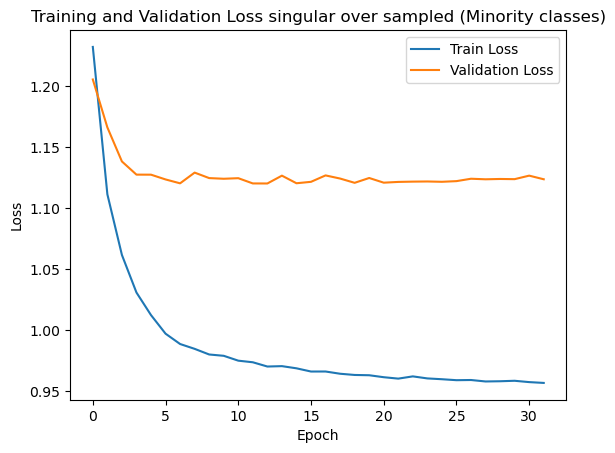

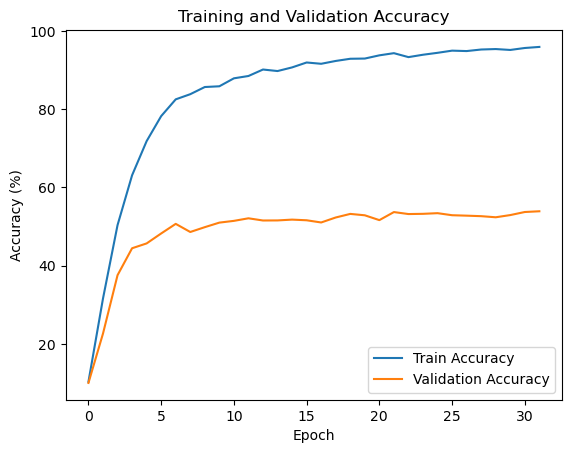

    Epoch  Train Loss  Train Accuracy  Val Loss  Val Accuracy
0       1    1.232170       10.337430  1.205489     10.046773
1       2    1.111395       31.606704  1.166221     22.656688
2       3    1.061685       50.359777  1.138307     37.567820
3       4    1.030895       63.097207  1.127509     44.452760
4       5    1.012399       71.821229  1.127474     45.687558
5       6    0.997174       78.212291  1.123572     48.231993
6       7    0.988702       82.493855  1.120382     50.682881
7       8    0.984740       83.812291  1.129172     48.606174
8       9    0.980118       85.644693  1.124674     49.840973
9      10    0.979039       85.832402  1.124129     51.000935
10     11    0.975054       87.865922  1.124595     51.449953
11     12    0.973739       88.460335  1.120296     52.104771
12     13    0.970252       90.113966  1.120257     51.543499
13     14    0.970570       89.725140  1.126671     51.562208
14     15    0.968791       90.654749  1.120445     51.768007
15     1

In [56]:
plt.plot(range(num_epochs_runned), train_losses, label="Train Loss")
plt.plot(range(num_epochs_runned), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss singular over sampled (Minority classes)')
plt.show()

# Plot training and validation accuracy
plt.plot(range(num_epochs_runned), train_accuracies, label="Train Accuracy")
plt.plot(range(num_epochs_runned), val_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Save the results in a DataFrame for reporting
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_runned + 1),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies
})

print(results_df)